# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu.


## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    IV. Summary 
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78701?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78753?</a></li>     
><li><a href="#q4"> 4. How is crime distributed in 78741?</a></li>
><li><a href="#q5"> 5. How is crime distributed in 78745?</a></li>
><li><a href="#q6"> 6. How is crime distributed in 78705?</a></li>
><li><a href="#q7"> 7. How are violent crimes, in particular murder, capital murder, armed robbery, aggrivated assault, and rape distributed?
><li><a href="#q8"> 8. How is crime distributed across different districts and sectors around Austin? Location types?
><li><a href="#q9"> 9. How does violent crime appear on the map?
><li><a href="#q10"> 10. Are there any addresses where violent crime and murder occurs frequently?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is updated weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I first attempted importing the data into this notebook using Sodapy's Socrata API method but found it lacking. It didn't import the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
# importing necessary libraries and configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium import plugins
import warnings

plt.style.use("fivethirtyeight")
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
# loading the data
df = pd.read_csv(r"C:\Users\Robert\Crime Reports Analysis\crime_reports.csv")

In [3]:
# examining the dataframe
display(df.shape)
display(df.info())
display(df.isnull().sum())
display(df.head())
display(df.tail())

(2294969, 27)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2294969 entries, 0 to 2294968
Data columns (total 27 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Incident Number              int64  
 1   Highest Offense Description  object 
 2   Highest Offense Code         int64  
 3   Family Violence              object 
 4   Occurred Date Time           object 
 5   Occurred Date                object 
 6   Occurred Time                float64
 7   Report Date Time             object 
 8   Report Date                  object 
 9   Report Time                  float64
 10  Location Type                object 
 11  Address                      object 
 12  Zip Code                     float64
 13  Council District             float64
 14  APD Sector                   object 
 15  APD District                 object 
 16  PRA                          object 
 17  Census Tract                 float64
 18  Clearance Status             object 
 19  

None

Incident Number                      0
Highest Offense Description          0
Highest Offense Code                 0
Family Violence                      0
Occurred Date Time                 165
Occurred Date                        0
Occurred Time                       84
Report Date Time                     1
Report Date                          0
Report Time                          1
Location Type                    20871
Address                             12
Zip Code                         14090
Council District                 47079
APD Sector                        8942
APD District                      9417
PRA                              10675
Census Tract                   1544285
Clearance Status                605250
Clearance Date                  336044
UCR Category                   1512748
Category Description           1512748
X-coordinate                     10097
Y-coordinate                     10097
Latitude                         38747
Longitude                

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,Location Type,Address,Zip Code,Council District,APD Sector,APD District,PRA,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
0,20191571574,FRAUD - OTHER,1199,N,06/03/2019 04:00:00 PM,06/03/2019,1600.0,06/06/2019 05:34:00 PM,06/06/2019,1734.0,DEPARTMENT / DISCOUNT STORE,10817 BALLARD PATH,78717.0,6.0,AD,5,573,203.11,NaN,NaN,NaN,NaN,3097785.0,3097785.0,30.483646,-97.789495,"(30.48364631, -97.7894953)"
1,20191550153,DEADLY CONDUCT,408,N,06/04/2019 03:12:00 AM,06/04/2019,312.0,06/04/2019 03:16:00 AM,06/04/2019,316.0,RESIDENCE / HOME,8312 N IH 35 SVRD SB,78753.0,4.0,ED,1,250,18.06,N,06/06/2019,13A,Aggravated Assault,3128227.0,3128227.0,30.346646,-97.696573,"(30.34664576, -97.69657342)"
2,20195022816,THEFT OF LICENSE PLATE,614,N,06/03/2019 03:00:00 PM,06/03/2019,1500.0,06/04/2019 03:22:00 PM,06/04/2019,1522.0,RESIDENCE / HOME,6312 LIBYAN DR,78745.0,2.0,FR,4,509,24.09,N,06/04/2019,23G,Theft,3098393.0,3098393.0,30.205267,-97.794900,"(30.20526729, -97.79490043)"
3,20205007833,RUNAWAY CHILD,4100,N,02/22/2020 06:00:00 PM,02/22/2020,1800.0,02/24/2020 06:03:00 PM,02/24/2020,1803.0,RESIDENCE / HOME,13012 DEARBONNE DR,78617.0,2.0,HE,7,612,NaN,N,03/03/2020,NaN,NaN,3155456.0,3155456.0,30.176140,-97.615031,"(30.17613952, -97.6150307)"
4,20191671388,BURGLARY OF RESIDENCE,500,N,06/14/2019 12:00:00 PM,06/14/2019,1200.0,06/16/2019 10:00:00 PM,06/16/2019,2200.0,RESIDENCE / HOME,3809 SPICEWOOD SPRINGS RD EB,78731.0,10.0,BA,8,256,17.51,N,09/18/2019,220,Burglary,3111039.0,3111039.0,30.364987,-97.750587,"(30.36498691, -97.75058749)"


,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,Location Type,Address,Zip Code,Council District,APD Sector,APD District,PRA,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
2294964,20203470893,AUTO THEFT,700,N,12/11/2020 11:40:00 PM,12/11/2020,2340.0,12/12/2020 05:44:00 PM,12/12/2020,1744.0,COMMERCIAL / OFFICE BUILDING,11119 ALTERRA PKWY,78758.0,7.0,AD,2,201,NaN,NaN,NaN,240,Auto Theft,3120138.0,3120138.0,30.396314,-97.720880,"(30.39631423, -97.72087952)"
2294965,20203520197,ASSAULT W/INJURY-FAM/DATE VIOL,900,Y,12/17/2020 05:36:00 AM,12/17/2020,536.0,12/17/2020 05:36:00 AM,12/17/2020,536.0,RESIDENCE / HOME,4509 E ST ELMO RD,78744.0,2.0,FR,5,495,NaN,NaN,NaN,NaN,NaN,3116164.0,3116164.0,30.205492,-97.738623,"(30.20549246, -97.73862345)"
2294966,20073640819,THEFT,600,N,12/30/2007 12:50:00 PM,12/30/2007,1250.0,12/30/2007 12:50:00 PM,12/30/2007,1250.0,RESIDENCE / HOME,4404 E OLTORF ST,78741.0,3.0,HE,4,458,NaN,NaN,01/07/2008,23H,Theft,3119889.0,3119889.0,30.227065,-97.726246,"(30.22706496, -97.72624614)"
2294967,20203521244,UNLAWFUL RESTRAINT FAM/DAT VIO,2805,Y,12/17/2020 07:36:00 PM,12/17/2020,1936.0,12/17/2020 07:36:00 PM,12/17/2020,1936.0,RESIDENCE / HOME,2823 E MARTIN LUTHER KING JR BLVD,78702.0,1.0,CH,3,393,NaN,NaN,NaN,NaN,NaN,3124423.0,3124423.0,30.281133,-97.710418,"(30.28113275, -97.71041775)"
2294968,20203461036,BURGLARY OF VEHICLE,601,N,12/11/2020 05:33:00 PM,12/11/2020,1733.0,12/11/2020 05:33:00 PM,12/11/2020,1733.0,STREETS / HWY / ROAD / ALLEY,9500 S IH 35 SVRD SB,78748.0,5.0,FR,2,666,NaN,NaN,NaN,23F,Theft,3099306.0,3099306.0,30.162911,-97.793123,"(30.16291061, -97.79312325)"


## II. Data Prep

There are several columns we don't need which we'll drop. We'll index the data according to the OCCURRED DATE TIME column. The following code creates a reproducible script for scrubbing and parsing the data.

In [4]:
def clean_data(df):
    drop_col = [
        "Incident Number",
        "Occurred Time",
        "Occurred Date",
        "Highest Offense Code",
        "Census Tract",
        "PRA",
        "Report Date",
        "Report Time",
        "UCR Category",
        "Category Description",
        "X-coordinate",
        "Y-coordinate",
        "Location",
    ]
    clean_col = ["Occurred Date Time"]
    df.drop(drop_col, axis=1, inplace=True)
    df.dropna(subset=clean_col, inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
    df.replace(" ", np.nan, inplace=True)
    date_col = ["occurred_date_time", "report_date_time", "clearance_date"]
    cat_col = [
        "highest_offense_description",
        "zip_code",
        "location_type",
        "council_district",
        "apd_district",
        "apd_sector",
    ]
    df[date_col] = df[date_col].astype("datetime64")
    df[cat_col] = df[cat_col].astype("category")
    df["year"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.year
    df["month"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.month
    df["week"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.week
    df["day"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.day
    df["hour"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.hour
    df.set_index(["occurred_date_time"], inplace=True)
    df.sort_index(inplace=True)
    return df


df = clean_data(df)

In [5]:
# reexamining the dataframe
display(df.shape)
display(df.info())
display(df.isnull().sum())
display(df.head())
display(df.tail())

(2294804, 18)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2294804 entries, 2003-01-01 00:00:00 to 2020-12-19 20:57:00
Data columns (total 18 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   highest_offense_description  category      
 1   family_violence              object        
 2   report_date_time             datetime64[ns]
 3   location_type                category      
 4   address                      object        
 5   zip_code                     category      
 6   council_district             category      
 7   apd_sector                   category      
 8   apd_district                 category      
 9   clearance_status             object        
 10  clearance_date               datetime64[ns]
 11  latitude                     float64       
 12  longitude                    float64       
 13  year                         int64         
 14  month                        int64         
 15  week            

None

highest_offense_description         0
family_violence                     0
report_date_time                    0
location_type                   20787
address                            12
zip_code                        14077
council_district                47066
apd_sector                       8940
apd_district                     9415
clearance_status               605214
clearance_date                 335978
latitude                        38741
longitude                       38741
year                                0
month                               0
week                                0
day                                 0
hour                                0
dtype: int64

,highest_offense_description,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,clearance_status,clearance_date,latitude,longitude,year,month,week,day,hour
occurred_date_time,,,,,,,,,,,,,,,,,,
2003-01-01,IDENTITY THEFT,N,2008-05-10 18:36:00,RESIDENCE / HOME,7312 WHISPERING OAKS DR,78745.0,5.0,FR,1,NaN,2008-05-13,30.202175,-97.817542,2003,1,1,1,0
2003-01-01,IDENTITY THEFT,N,2009-08-07 14:23:00,RESIDENCE / HOME,6800 MC NEIL DR,78729.0,6.0,AD,4,NaN,NaT,30.438983,-97.759669,2003,1,1,1,0
2003-01-01,INDECENCY WITH A CHILD/CONTACT,Y,2007-05-10 09:52:00,RESIDENCE / HOME,9400 BLOCK GROUSE MEADOW LN,78758.0,4.0,ED,1,C,2007-07-02,NaN,NaN,2003,1,1,1,0
2003-01-01,IDENTITY THEFT,N,2012-01-23 09:41:00,SPECIALTY STORE (TV FUR ETC.),1533 CUTTING HORSE LN,78727.0,7.0,ED,4,N,2012-01-23,30.416668,-97.683656,2003,1,1,1,0
2003-01-01,INDECENCY WITH A CHILD/CONTACT,Y,2017-10-02 21:14:00,RESIDENCE / HOME,1200 BLOCK AUSTIN HIGHLANDS BLVD,78745.0,2.0,FR,4,N,2018-08-02,NaN,NaN,2003,1,1,1,0


,highest_offense_description,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,clearance_status,clearance_date,latitude,longitude,year,month,week,day,hour
occurred_date_time,,,,,,,,,,,,,,,,,,
2020-12-19 18:55:00,BURGLARY OF RESIDENCE,N,2020-12-19 19:14:00,RESIDENCE / HOME,4404 E OLTORF ST,78741.0,3.0,HE,4,NaN,NaT,30.227065,-97.726246,2020,12,51,19,18
2020-12-19 19:00:00,HARASSMENT,N,2020-12-19 21:07:00,RESIDENCE / HOME,4806 MISTY SLOPE LN,78744.0,2.0,FR,8,NaN,NaT,30.177491,-97.753304,2020,12,51,19,19
2020-12-19 19:33:00,THEFT FROM AUTO,N,2020-12-19 19:33:00,RESIDENCE / HOME,504 BLUE VALLEY DR,78748.0,2.0,FR,3,NaN,NaT,30.182568,-97.790536,2020,12,51,19,19
2020-12-19 19:38:00,FAMILY DISTURBANCE,N,2020-12-19 19:38:00,RESIDENCE / HOME,815 W SLAUGHTER LN,78748.0,5.0,FR,2,NaN,NaT,30.173685,-97.806397,2020,12,51,19,19
2020-12-19 20:57:00,AUTO THEFT,N,2020-12-19 20:57:00,GAS / SERVICE STATIONS,1747 E OLTORF ST,78741.0,3.0,HE,2,NaN,NaT,30.232066,-97.737400,2020,12,51,19,20


## III. Exploratory Analysis

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

78741.0    206224
78753.0    178379
78701.0    168082
78758.0    158711
78704.0    154213
78745.0    150408
78702.0    136490
78744.0    125943
78723.0    118058
78752.0     84221
78748.0     67866
78759.0     66106
78751.0     63909
78757.0     57688
78705.0     56942
78721.0     47593
78749.0     40312
78724.0     37569
78727.0     35755
78703.0     35107
78731.0     28557
78746.0     28066
78729.0     25210
78750.0     23614
78754.0     22727
Name: zip_code, dtype: int64

----------------------------------


78741.0    0.090420
78753.0    0.078211
78701.0    0.073697
78758.0    0.069588
78704.0    0.067616
78745.0    0.065947
78702.0    0.059845
78744.0    0.055221
78723.0    0.051763
78752.0    0.036927
78748.0    0.029756
78759.0    0.028985
78751.0    0.028021
78757.0    0.025294
78705.0    0.024967
78721.0    0.020867
78749.0    0.017675
78724.0    0.016472
78727.0    0.015677
78703.0    0.015393
78731.0    0.012521
78746.0    0.012306
78729.0    0.011053
78750.0    0.010354
78754.0    0.009965
Name: zip_code, dtype: float64

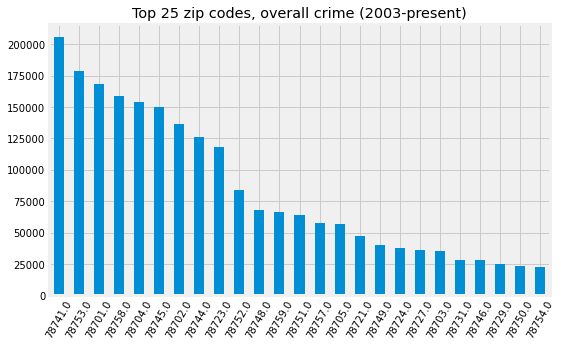

In [6]:
# Create and show dataframe for crime rates by zipcode and then as percentages
zip_codes = df.zip_code.value_counts().head(25)
display(zip_codes)
print("----------------------------------")
display(df.zip_code.value_counts(normalize=True).head(25))

# Visualizing the top 25 areas for crime
df.zip_code.value_counts().head(25).plot.bar(
    rot=60, title="Top 25 zip codes, overall crime (2003-present)", figsize=(8, 5)
)

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78701 (downtown Austin)? 

PUBLIC INTOXICATION               17148
THEFT                             15733
BURGLARY OF VEHICLE                9243
WARRANT ARREST NON TRAFFIC         8967
DWI                                8304
ASSAULT WITH INJURY                7491
VIOL CITY ORDINANCE - OTHER        6188
POSS OF DRUG PARAPHERNALIA         6028
CRIMINAL MISCHIEF                  5788
CRIMINAL TRESPASS                  3899
POSSESSION OF MARIJUANA            3378
DISTURBANCE - OTHER                3342
CUSTODY ARREST TRAFFIC WARR        3001
POSS CONTROLLED SUB/NARCOTIC       2893
CAMPING IN PARK                    2791
VOCO - ALCOHOL  CONSUMPTION        2690
CRIMINAL TRESPASS/TRANSIENT        2577
ASSAULT BY CONTACT                 2567
THEFT OF BICYCLE                   2500
URINATING IN PUBLIC PLACE          2336
FAMILY DISTURBANCE                 2139
DOC FIGHTING                       2105
PROTECTIVE ORDER                   2101
ASSAULT W/INJURY-FAM/DATE VIOL     1724
Name: highest_offense_description, dtype

----------------------------------


PUBLIC INTOXICATION               0.102022
THEFT                             0.093603
BURGLARY OF VEHICLE               0.054991
WARRANT ARREST NON TRAFFIC        0.053349
DWI                               0.049404
ASSAULT WITH INJURY               0.044568
VIOL CITY ORDINANCE - OTHER       0.036815
POSS OF DRUG PARAPHERNALIA        0.035863
CRIMINAL MISCHIEF                 0.034436
CRIMINAL TRESPASS                 0.023197
POSSESSION OF MARIJUANA           0.020097
DISTURBANCE - OTHER               0.019883
CUSTODY ARREST TRAFFIC WARR       0.017854
POSS CONTROLLED SUB/NARCOTIC      0.017212
CAMPING IN PARK                   0.016605
VOCO - ALCOHOL  CONSUMPTION       0.016004
CRIMINAL TRESPASS/TRANSIENT       0.015332
ASSAULT BY CONTACT                0.015272
THEFT OF BICYCLE                  0.014874
URINATING IN PUBLIC PLACE         0.013898
FAMILY DISTURBANCE                0.012726
DOC FIGHTING                      0.012524
PROTECTIVE ORDER                  0.012500
ASSAULT W/I

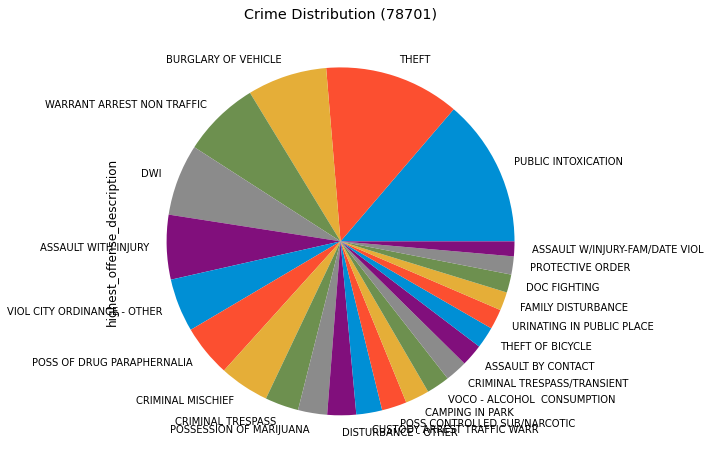

In [7]:
# Examining crime in the 78701 area
df_01 = df[df.zip_code == 78701]

# Create a dataframe for the top crime categories in the zipcode
df_01_off = df_01.highest_offense_description.value_counts().head(24)

# Display the different crime values & then as percentages
display(df_01_off)
print("----------------------------------")
display(df_01.highest_offense_description.value_counts(normalize=True).head(24))
df_01_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78701)")

<a id='q3'></a>
### C. Question 2. How is crime distributed in 78753? 

THEFT                             17093
BURGLARY OF VEHICLE               15923
FAMILY DISTURBANCE                14590
CRIMINAL MISCHIEF                  9431
THEFT BY SHOPLIFTING               7619
ASSAULT W/INJURY-FAM/DATE VIOL     7118
BURGLARY OF RESIDENCE              6052
DWI                                4978
DISTURBANCE - OTHER                4740
CUSTODY ARREST TRAFFIC WARR        4343
HARASSMENT                         4232
AUTO THEFT                         4184
POSS OF DRUG PARAPHERNALIA         3720
PUBLIC INTOXICATION                3363
ASSAULT WITH INJURY                3294
CRIMINAL TRESPASS                  3132
POSS CONTROLLED SUB/NARCOTIC       2970
RUNAWAY CHILD                      2918
WARRANT ARREST NON TRAFFIC         2794
POSSESSION OF MARIJUANA            2697
BURGLARY NON RESIDENCE             2491
VIOL CITY ORDINANCE - OTHER        1866
Name: highest_offense_description, dtype: int64

----------------------------------


THEFT                             0.095824
BURGLARY OF VEHICLE               0.089265
FAMILY DISTURBANCE                0.081792
CRIMINAL MISCHIEF                 0.052871
THEFT BY SHOPLIFTING              0.042712
ASSAULT W/INJURY-FAM/DATE VIOL    0.039904
BURGLARY OF RESIDENCE             0.033928
DWI                               0.027907
DISTURBANCE - OTHER               0.026573
CUSTODY ARREST TRAFFIC WARR       0.024347
HARASSMENT                        0.023725
AUTO THEFT                        0.023456
POSS OF DRUG PARAPHERNALIA        0.020854
PUBLIC INTOXICATION               0.018853
ASSAULT WITH INJURY               0.018466
CRIMINAL TRESPASS                 0.017558
POSS CONTROLLED SUB/NARCOTIC      0.016650
RUNAWAY CHILD                     0.016358
WARRANT ARREST NON TRAFFIC        0.015663
POSSESSION OF MARIJUANA           0.015119
BURGLARY NON RESIDENCE            0.013965
VIOL CITY ORDINANCE - OTHER       0.010461
Name: highest_offense_description, dtype: float64

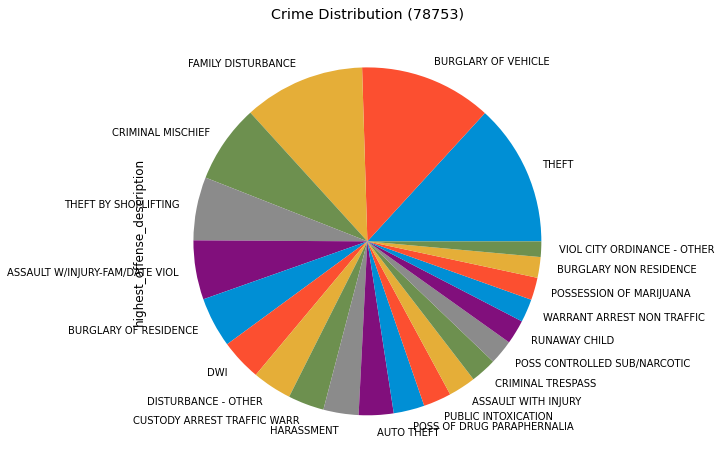

In [8]:
# Examining crime in the 78753 area
df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode
df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
display(df_53_off)
print("----------------------------------")
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))
df_53_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78753)")

<a id='q4'></a>
### D. Question 4. How is crime distributed in 78741 (E Riverside/Oltorf)? 

FAMILY DISTURBANCE                20275
BURGLARY OF VEHICLE               19770
THEFT                             15557
CRIMINAL MISCHIEF                 11006
ASSAULT W/INJURY-FAM/DATE VIOL     9602
BURGLARY OF RESIDENCE              8865
PUBLIC INTOXICATION                6375
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5641
HARASSMENT                         5488
DISTURBANCE - OTHER                5146
AUTO THEFT                         4593
ASSAULT WITH INJURY                4521
CRIMINAL TRESPASS                  3898
POSS CONTROLLED SUB/NARCOTIC       3845
POSSESSION OF MARIJUANA            3791
THEFT BY SHOPLIFTING               3572
POSS OF DRUG PARAPHERNALIA         3532
WARRANT ARREST NON TRAFFIC         3448
RUNAWAY CHILD                      2784
VIOL CITY ORDINANCE - OTHER        2196
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098315
BURGLARY OF VEHICLE               0.095867
THEFT                             0.075437
CRIMINAL MISCHIEF                 0.053369
ASSAULT W/INJURY-FAM/DATE VIOL    0.046561
BURGLARY OF RESIDENCE             0.042987
PUBLIC INTOXICATION               0.030913
CUSTODY ARREST TRAFFIC WARR       0.029148
DWI                               0.027354
HARASSMENT                        0.026612
DISTURBANCE - OTHER               0.024953
AUTO THEFT                        0.022272
ASSAULT WITH INJURY               0.021923
CRIMINAL TRESPASS                 0.018902
POSS CONTROLLED SUB/NARCOTIC      0.018645
POSSESSION OF MARIJUANA           0.018383
THEFT BY SHOPLIFTING              0.017321
POSS OF DRUG PARAPHERNALIA        0.017127
WARRANT ARREST NON TRAFFIC        0.016720
RUNAWAY CHILD                     0.013500
VIOL CITY ORDINANCE - OTHER       0.010649
Name: highest_offense_description, dtype: float64

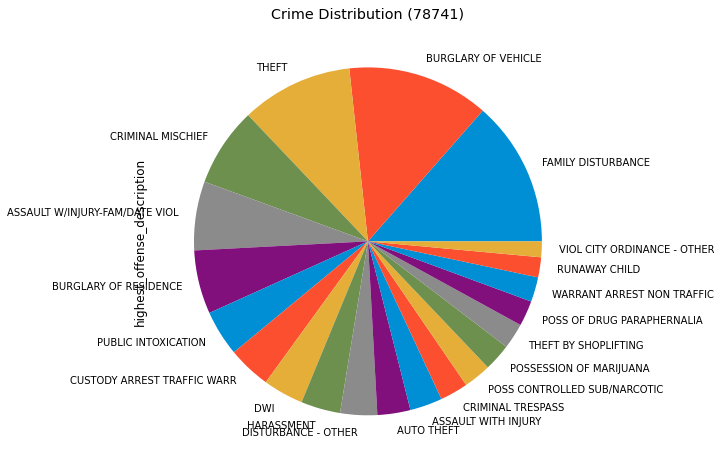

In [9]:
# Examining crime in the 78741 area (the highest amount of crime of any Austin zip code)
df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top crime categories in the zipcode
df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages
display(df_41_off)
print("----------------------------------")
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))
df_41_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78741)")

<a id='q5'></a>
### E. Question 5. How is crime distributed in 78745 (far south Austin)?

FAMILY DISTURBANCE                14861
BURGLARY OF VEHICLE               14744
THEFT                             13519
CRIMINAL MISCHIEF                  8483
BURGLARY OF RESIDENCE              5863
ASSAULT W/INJURY-FAM/DATE VIOL     5739
HARASSMENT                         5122
DISTURBANCE - OTHER                4498
DWI                                4403
PUBLIC INTOXICATION                3994
CUSTODY ARREST TRAFFIC WARR        3248
BURGLARY NON RESIDENCE             2918
AUTO THEFT                         2837
ASSAULT WITH INJURY                2656
RUNAWAY CHILD                      2591
POSSESSION OF MARIJUANA            2586
WARRANT ARREST NON TRAFFIC         2108
POSS CONTROLLED SUB/NARCOTIC       2012
THEFT BY SHOPLIFTING               1969
CRIMINAL TRESPASS                  1946
IDENTITY THEFT                     1567
POSS OF DRUG PARAPHERNALIA         1515
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098805
BURGLARY OF VEHICLE               0.098027
THEFT                             0.089882
CRIMINAL MISCHIEF                 0.056400
BURGLARY OF RESIDENCE             0.038981
ASSAULT W/INJURY-FAM/DATE VIOL    0.038156
HARASSMENT                        0.034054
DISTURBANCE - OTHER               0.029905
DWI                               0.029274
PUBLIC INTOXICATION               0.026554
CUSTODY ARREST TRAFFIC WARR       0.021595
BURGLARY NON RESIDENCE            0.019401
AUTO THEFT                        0.018862
ASSAULT WITH INJURY               0.017659
RUNAWAY CHILD                     0.017226
POSSESSION OF MARIJUANA           0.017193
WARRANT ARREST NON TRAFFIC        0.014015
POSS CONTROLLED SUB/NARCOTIC      0.013377
THEFT BY SHOPLIFTING              0.013091
CRIMINAL TRESPASS                 0.012938
IDENTITY THEFT                    0.010418
POSS OF DRUG PARAPHERNALIA        0.010073
Name: highest_offense_description, dtype: float64

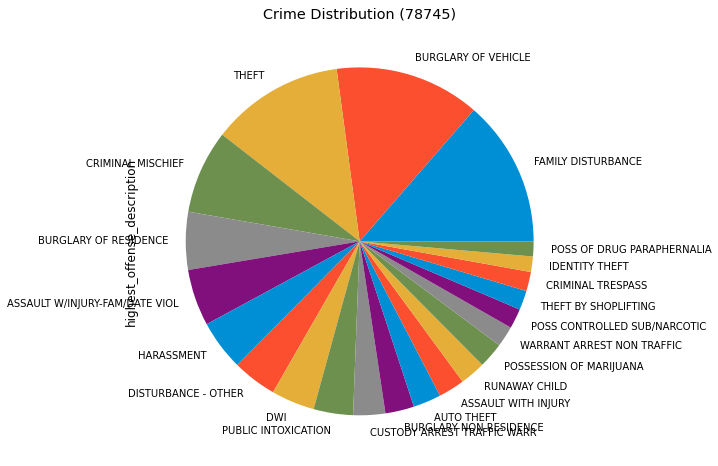

In [10]:
# Examining crime in the 78745 area
df_45 = df[df.zip_code == 78745]

# Create a dataframe for the top 10 crime categories in the zipcode
df_45_off = df_45.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
display(df_45_off)
print("----------------------------------")
display(df_45.highest_offense_description.value_counts(normalize=True).head(22))
df_45_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78745)")

<a id='q6'></a>
### F. Question 6. How is crime distributed in 78705 (UT campus area)?

BURGLARY OF VEHICLE               8602
THEFT                             5592
CRIMINAL MISCHIEF                 4953
THEFT OF BICYCLE                  3463
PUBLIC INTOXICATION               2626
BURGLARY OF RESIDENCE             2116
WARRANT ARREST NON TRAFFIC        1548
CRIMINAL TRESPASS                 1340
AUTO THEFT                        1299
ASSAULT WITH INJURY               1243
DWI                               1219
HARASSMENT                        1210
FAMILY DISTURBANCE                1180
DISTURBANCE - OTHER               1113
BURGLARY NON RESIDENCE             873
CRIMINAL TRESPASS/TRANSIENT        868
VIOL CITY ORDINANCE - OTHER        791
CUSTODY ARREST TRAFFIC WARR        783
GRAFFITI                           775
ASSAULT W/INJURY-FAM/DATE VIOL     689
POSSESSION OF MARIJUANA            658
ASSAULT BY CONTACT                 612
Name: highest_offense_description, dtype: int64

----------------------------------


BURGLARY OF VEHICLE               0.151066
THEFT                             0.098205
CRIMINAL MISCHIEF                 0.086983
THEFT OF BICYCLE                  0.060816
PUBLIC INTOXICATION               0.046117
BURGLARY OF RESIDENCE             0.037161
WARRANT ARREST NON TRAFFIC        0.027186
CRIMINAL TRESPASS                 0.023533
AUTO THEFT                        0.022813
ASSAULT WITH INJURY               0.021829
DWI                               0.021408
HARASSMENT                        0.021250
FAMILY DISTURBANCE                0.020723
DISTURBANCE - OTHER               0.019546
BURGLARY NON RESIDENCE            0.015331
CRIMINAL TRESPASS/TRANSIENT       0.015244
VIOL CITY ORDINANCE - OTHER       0.013891
CUSTODY ARREST TRAFFIC WARR       0.013751
GRAFFITI                          0.013610
ASSAULT W/INJURY-FAM/DATE VIOL    0.012100
POSSESSION OF MARIJUANA           0.011556
ASSAULT BY CONTACT                0.010748
Name: highest_offense_description, dtype: float64

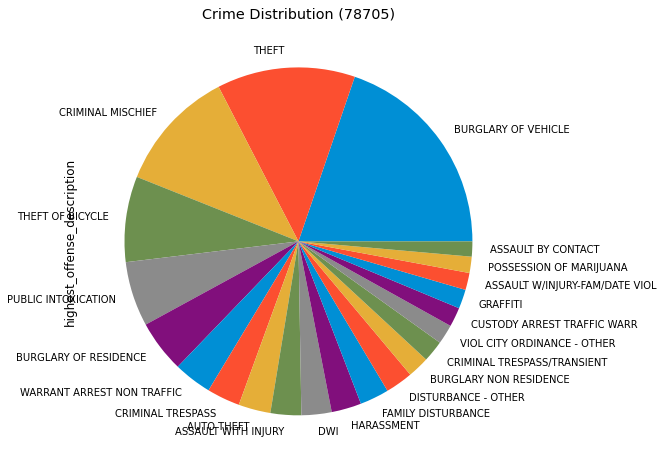

In [11]:
# Examining crime in the 78705 area
df_05 = df[df.zip_code == 78705]

# Create a dataframe for the top 10 crime categories in the zipcode
df_05_off = df_05.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
display(df_05_off)
print("----------------------------------")
display(df_05.highest_offense_description.value_counts(normalize=True).head(22))
df_05_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78705)")

<a id='q7'></a>
### H. Question 7. How are violent crimes, in particular murder, capital murder, armed robbery, aggrivated assault, and rape distributed? 

In [12]:
# Creating separate dataframes for overall & violent crime
df_viol = df.query(
    'highest_offense_description == ["AGG ASSAULT", "AGG ROBBERY/DEADLY WEAPON", "CAPITAL MURDER", "MURDER", "RAPE"]'
)
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_agg_asslt = df[df.highest_offense_description == "AGG ASSAULT"]
df_agg_robbery = df[df.highest_offense_description == "AGG ROBBERY/DEADLY WEAPON"]

# Creating yearly dataframes
# Annual overall crime
df_17 = df[df.year == 2017]
df_18 = df[df.year == 2018]
df_19 = df[df.year == 2019]
df_20 = df[df.year == 2020]

# Annual violent crime
df_viol_17 = df_viol[df_viol.year == 2017]
df_viol_18 = df_viol[df_viol.year == 2018]
df_viol_19 = df_viol[df_viol.year == 2019]
df_viol_20 = df_viol[df_viol.year == 2020]

# Annual murders
df_viol_mur_17 = df_viol_mur[df_viol_mur.year == 2017]
df_viol_mur_18 = df_viol_mur[df_viol_mur.year == 2018]
df_viol_mur_19 = df_viol_mur[df_viol_mur.year == 2019]
df_viol_mur_20 = df_viol_mur[df_viol_mur.year == 2020]

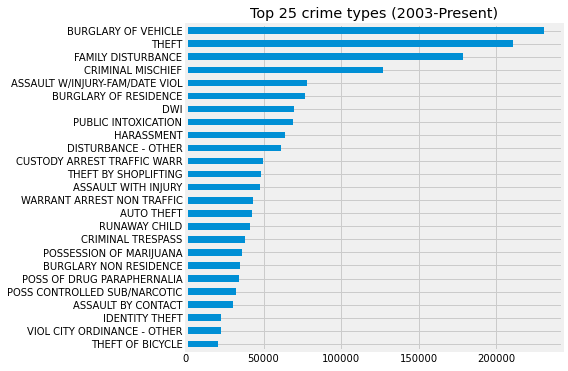

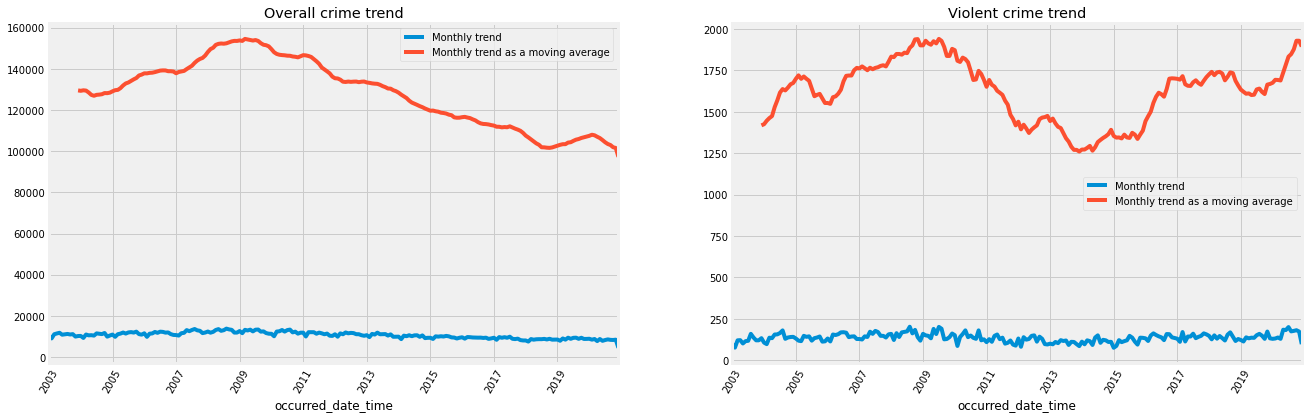

In [13]:
# Top 25 crime types
df.highest_offense_description.value_counts().head(25).sort_values().plot.barh(
    figsize=(6, 6), title="Top 25 crime types (2003-Present)"
)
plt.show()

# Visualizing trends (overall and violent)
fig, axs = plt.subplots(ncols=2, figsize=(20, 6.25))
df.resample("M").size().plot(ax=axs[0])
df.resample("M").size().rolling(12).sum().plot(
    title="Overall crime trend", rot=60, ax=axs[0]
)
axs[0].legend(["Monthly trend", "Monthly trend as a moving average"])
df_viol.resample("M").size().plot(ax=axs[1])
df_viol.resample("M").size().rolling(12).sum().plot(
    title="Violent crime trend", rot=60, ax=axs[1]
)
axs[1].legend(["Monthly trend", "Monthly trend as a moving average"])
plt.show()

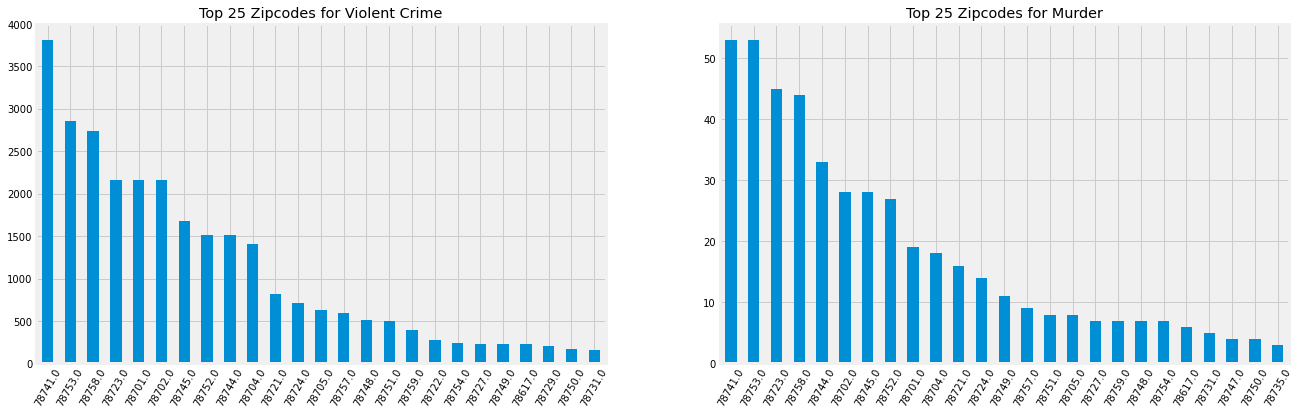

highest_offense_description,AGG ASSAULT,AGG ROBBERY/DEADLY WEAPON,CAPITAL MURDER,MURDER,RAPE
zip_code,,,,,
78610.0,1,0,0,0,0
78613.0,14,11,0,1,6
78617.0,121,62,0,6,36
78621.0,1,0,0,0,0
78634.0,1,0,0,0,0
78652.0,2,0,0,0,0
78653.0,10,3,0,1,1
78660.0,65,28,0,2,17
78664.0,3,0,0,0,0


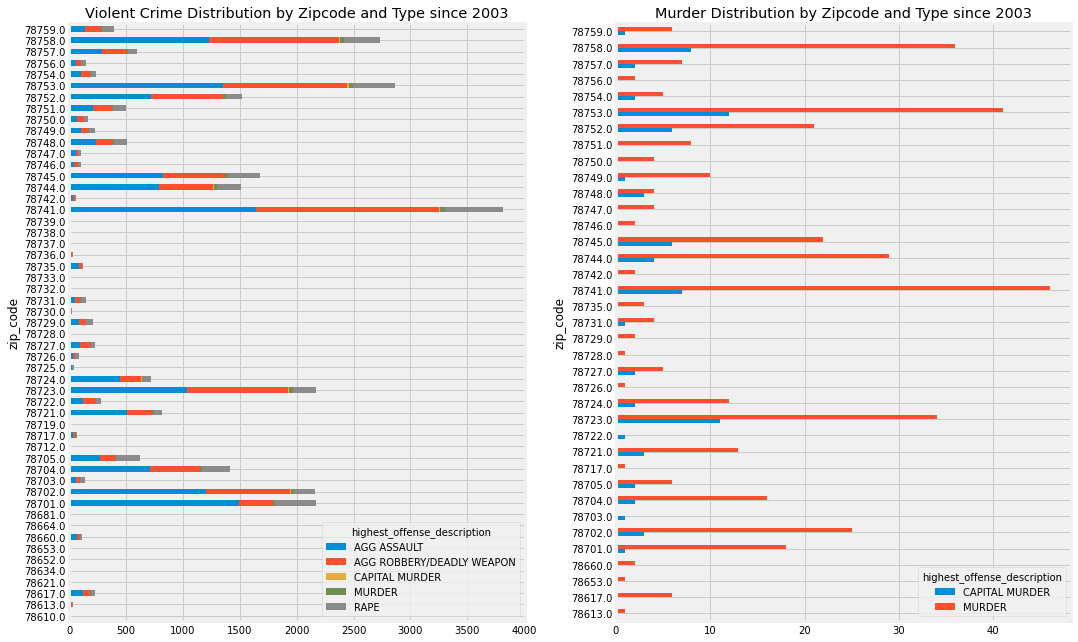

In [14]:
fig, axs = plt.subplots(figsize=(20, 6.25), ncols=2)
df_viol.zip_code.value_counts().head(25).plot.bar(
    title="Top 25 Zipcodes for Violent Crime", rot=60, ax=axs[0]
)
df_viol_mur.zip_code.value_counts().head(25).plot.bar(
    title="Top 25 Zipcodes for Murder", rot=60, ax=axs[1]
)
plt.show()

viol_freq = pd.crosstab(df_viol.zip_code, df_viol.highest_offense_description)
mur_freq = pd.crosstab(df_viol_mur.zip_code, df_viol_mur.highest_offense_description)
display(viol_freq)

fig, axs = plt.subplots(figsize=(16, 11), ncols=2)
viol_freq.plot.barh(
    title="Violent Crime Distribution by Zipcode and Type since 2003",
    ax=axs[0],
    stacked=True,
)
mur_freq.plot.barh(
    title="Murder Distribution by Zipcode and Type since 2003", ax=axs[1]
)
plt.show()

#### Distribution of violent crime and murders across council districts, APD Districts, and APD sectors 

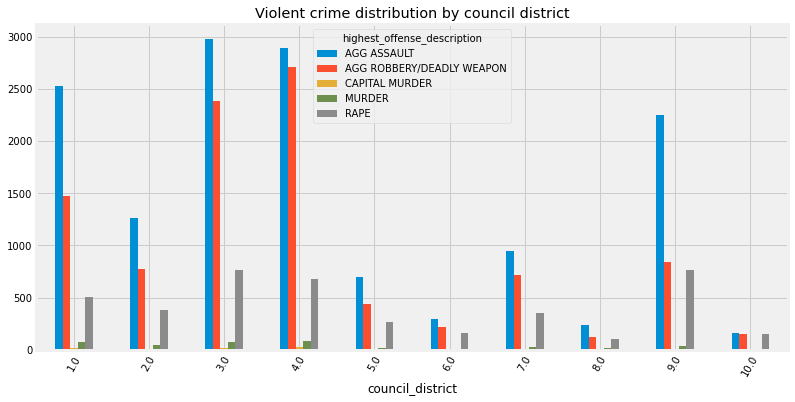

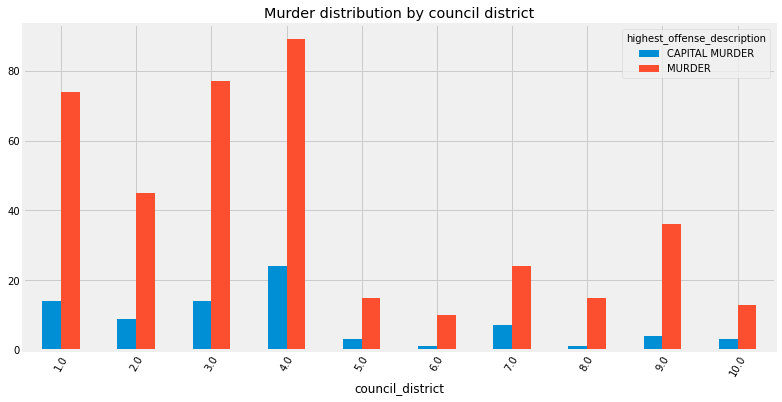

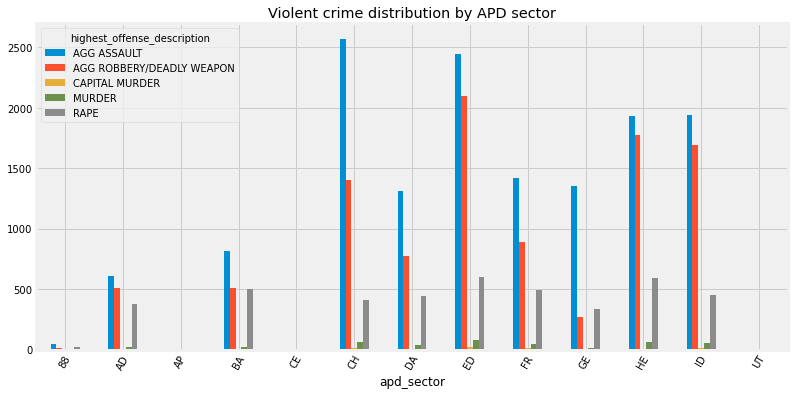

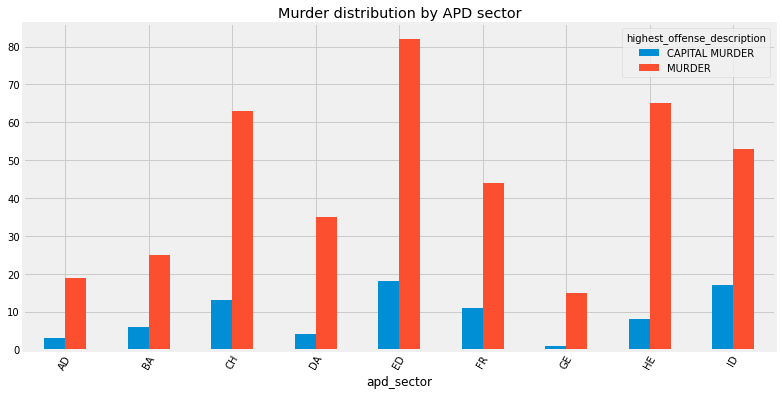

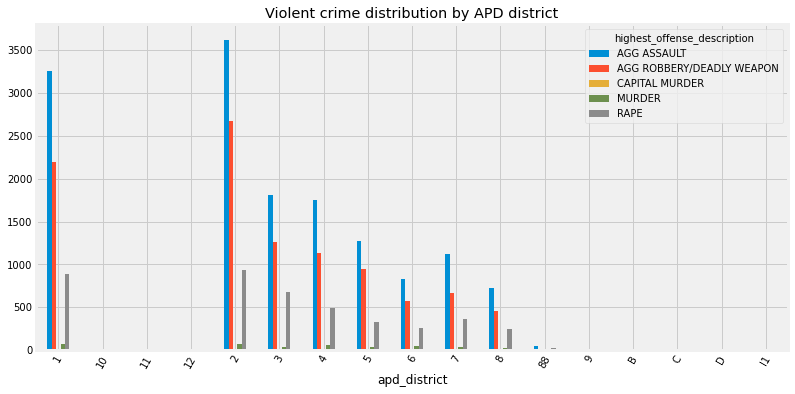

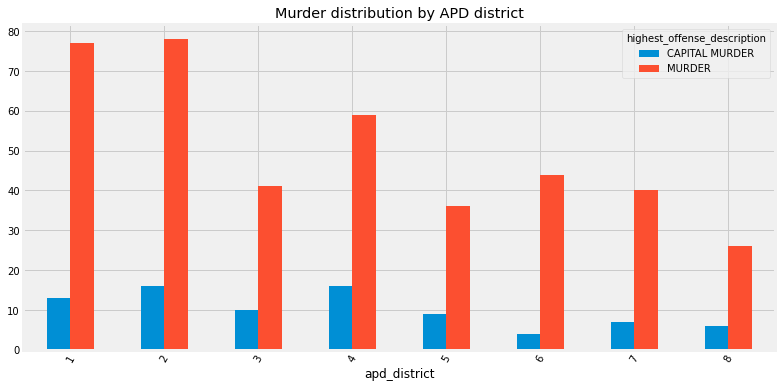

In [15]:
pd.crosstab(df_viol.council_district, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Violent crime distribution by council district"
)
plt.show()

pd.crosstab(
    df_viol_mur.council_district, df_viol_mur.highest_offense_description
).plot.bar(figsize=(12, 6), rot=60, title="Murder distribution by council district")
plt.show()

pd.crosstab(df_viol.apd_sector, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Violent crime distribution by APD sector"
)
plt.show()

pd.crosstab(df_viol_mur.apd_sector, df_viol_mur.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Murder distribution by APD sector"
)
plt.show()

pd.crosstab(df_viol.apd_district, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Violent crime distribution by APD district"
)
plt.show()

pd.crosstab(df_viol_mur.apd_district, df_viol_mur.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Murder distribution by APD district"
)
plt.show()

#### Violent crime and murder distribution by location type

highest_offense_description,AGG ASSAULT,AGG ROBBERY/DEADLY WEAPON,CAPITAL MURDER,MURDER,RAPE
location_type,,,,,
ABANDONED/CONDEMNED STRUCTURE,13,7,0,1,4
AMUSEMENT PARK,0,1,0,1,0
ARENA / STADIUM / FAIRGROUNDS / COLISEUM,2,0,0,0,0
ATM SEPARATE FROM BANK,1,2,0,0,0
AUTO DEALERSHIP NEW / USED,10,2,0,0,1
BANKS / SAVINGS & LOAN,5,134,0,1,1
BAR / NIGHT CLUB,652,45,2,7,77
CAMP / CAMPGROUND,20,2,0,0,2
CHURCH / SYNAGOGUE / TEMPLE / MOSQUE,20,5,1,0,7


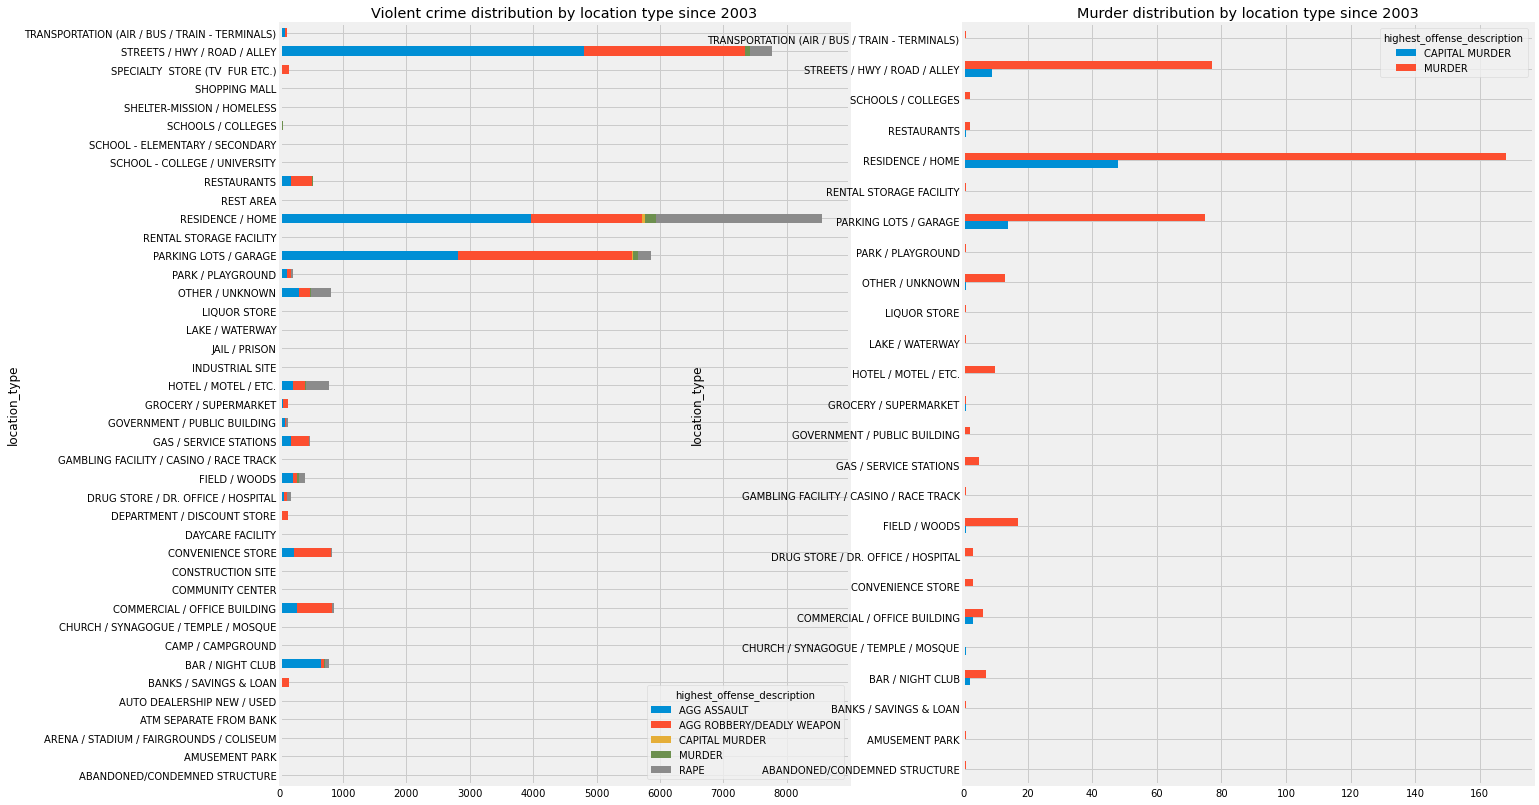

In [16]:
viol_loc = pd.crosstab(df_viol.location_type, df_viol.highest_offense_description)
display(viol_loc)
mur_loc = pd.crosstab(
    df_viol_mur.location_type, df_viol_mur.highest_offense_description
)

fig, axs = plt.subplots(figsize=(20, 14), ncols=2)
viol_loc.plot.barh(
    title="Violent crime distribution by location type since 2003",
    ax=axs[0],
    stacked=True,
)
mur_loc.plot.barh(title="Murder distribution by location type since 2003", ax=axs[1])
plt.show()

<a id='q9'></a>
### I. Question 9. How does violent crime appear on the map?

** Note: Rape incidents provide no location coordinates therefore cannot be shown on a map. **

#### Aggravated assault 

In [17]:
# Aggravated assault as a heatmap
agg_asslt_coords_heat = df_agg_asslt[
    (df_agg_asslt["latitude"].isnull() == False)
    & (df_agg_asslt["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(agg_asslt_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="agg_asslt_heatmap.html")

k

#### Armed robbery 

In [18]:
agg_robbery_coords_heat = df_agg_robbery[
    (df_agg_robbery["latitude"].isnull() == False)
    & (df_agg_robbery["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(
        agg_robbery_coords_heat[["latitude", "longitude"]].values, radius=15
    )
)

k.save(outfile="agg_robbery_heatmap.html")

k

<a id='q8'></a>
#### Murder  

In [19]:
# As a heatmap
mur_coords_heat = df_viol_mur[
    (df_viol_mur["latitude"].isnull() == False)
    & (df_viol_mur["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(mur_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="mur_heatmap.html")

k

<a id='q10'></a>
### J. Question 10. Are there any addresses where violent crime and murder occurs frequently?

In [20]:
# Show addresses with 50 or more reported violent crimes
df_viol.address.value_counts().head(13)

500 E 7TH ST                83
9515 N LAMAR BLVD           66
1700 BURTON DR              62
00 BLOCK UNKNOWN            59
6409 SPRINGDALE RD          59
9601 MIDDLE FISKVILLE RD    58
900 BLOCK E 32ND ST         54
9200 NORTH PLZ              53
1030 NORWOOD PARK BLVD      53
1071 CLAYTON LN             53
2237 E RIVERSIDE DR         51
1137 GUNTER ST              51
1124 RUTLAND DR             50
Name: address, dtype: int64

In [21]:
# Show addresses with 2 or more reported murders
df_viol_mur.address.value_counts().head(31)

8800 N IH 35 SVRD SB         3
6407 SPRINGDALE RD           3
6409 SPRINGDALE RD           3
4700 E RIVERSIDE DR          3
8610 N LAMAR BLVD            3
605 MASTERSON PASS           2
1050 SPRINGDALE RD           2
6600 ED BLUESTEIN BLVD SB    2
10503 N LAMAR BLVD           2
8912 N LAMAR BLVD            2
6118 FAIRWAY ST              2
2915 S IH 35 SVRD NB         2
2101 ELMONT DR               2
815 W SLAUGHTER LN           2
9601 MIDDLE FISKVILLE RD     2
9010 GALEWOOD DR             2
2400 WICKERSHAM LN           2
833 FAIRFIELD DR             2
9200 NORTH PLZ               2
7000 DECKER LN               2
8225 SAM RAYBURN DR          2
2713 S CONGRESS AVE          2
201 W 5TH ST                 2
1711 RUTLAND DR              2
2508 E RIVERSIDE DR          2
1137 GUNTER ST               2
9220 N IH 35 SVRD SB         2
601 E 15TH ST                2
744 W WILLIAM CANNON DR      2
10610 MORADO CIR             2
2501 ANKEN DR                2
Name: address, dtype: int64

## IV. Summary 

Between 2003 and now, crime peaked in 2008 and continued a downward trend until 2019 when it rose again. Since we're still in 2020, we have to wait until the end of the year to see what 2020 yields. 

Out of all the areas in Austin, 78741 has the highest percentage of overall crime at 9.05%. This is a significant 1.23 percentage points higher than the number 2 area 78753 which hosts 7.82% of overall crime.

As we can see, violent crime spiked tremendously after 2018, and especially for 2020 so far.

Years 2010 and 2016 had the most number of murders. However, and alarmingly, as of 11/23/2020, we've now had more murders this year than any other since 2003. Presently, the murder count for 2020 is at 39!!

So, you're most likely to get murdered in July, between 1 and 2am, in the 78753 zip code, with 78741 coming in as a very strong alternate. Good to know!

In [22]:
df_clean = df.copy()
df_clean.to_csv("df_clean.csv")

df_17.to_csv("df_17.csv")
df_18.to_csv("df_18.csv")
df_19.to_csv("df_19.csv")
df_20.to_csv("df_20.csv")

df_viol_17.to_csv("df_viol_17.csv")
df_viol_18.to_csv("df_viol_18.csv")
df_viol_19.to_csv("df_viol_19.csv")
df_viol_20.to_csv("df_viol_20.csv")

df_viol_mur_17.to_csv("df_viol_mur_17.csv")
df_viol_mur_18.to_csv("df_viol_mur_18.csv")
df_viol_mur_19.to_csv("df_viol_mur_19.csv")
df_viol_mur_20.to_csv("df_viol_mur_20.csv")

df_viol.to_csv("df_viol.csv")
df_viol_mur.to_csv("df_viol_mur.csv")

df_01.to_csv("df_01.csv")
df_53.to_csv("df_53.csv")
df_41.to_csv("df_41.csv")
df_45.to_csv("df_45.csv")
df_05.to_csv("df_05.csv")